In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 

In [2]:
import os
import sys

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

from utils.utils import *
from utils.dataset import ChronsiteDataset
from utils.configs import ChronsiteConfig
import pandas as pd


from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.config import Config
from mrcnn.model import log
import random
import tqdm


import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
# Define working directories

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "eleven_images")

# Checkpoint of trained model to reload
MODEL_BRANCH = "chronsite20201003T1222"
CHECKPOINT_EPOCH = 77

IMAGE_COLLECTION_PATH = os.path.join(ROOT_DIR, "image_collection_bis.json")

# 1. Fetch metadata, prepare dataset for evaluation

In [4]:
# Fetch metadata
records = fetch_train_set()

In [5]:
# Distribution by construction site
records.construction_site.value_counts()

Analytic2                         2155
Analytic                           999
Marseille_01                       779
Devisubox2_06                      294
Nouveau_campus_03                  260
Roissy_02                          152
BioSAV_BIofiltration_18mois_05      97
Name: construction_site, dtype: int64

In [6]:
records.head(5)

,sample_id,construction_site,image_blob_id,date_time,annotation_people_blob_id,annotation_poly_blob_id,annotation_blob_id
0,2020-08-06-07-00-08,Analytic2,Analytics_Train_Set/Analytics_Train_Set_Img/20...,2020-08-06 07:00:08,Analytics_Train_Set/Analytics_Train_Set_Json/p...,Analytics_Train_Set/Analytics_Train_Set_Json/p...,NaN
1,2020-08-06-07-00-56,Analytic2,Analytics_Train_Set/Analytics_Train_Set_Img/20...,2020-08-06 07:00:56,Analytics_Train_Set/Analytics_Train_Set_Json/p...,Analytics_Train_Set/Analytics_Train_Set_Json/p...,NaN
2,2020-08-06-07-01-43,Analytic2,Analytics_Train_Set/Analytics_Train_Set_Img/20...,2020-08-06 07:01:43,Analytics_Train_Set/Analytics_Train_Set_Json/p...,Analytics_Train_Set/Analytics_Train_Set_Json/p...,NaN
3,2020-08-06-07-02-30,Analytic2,Analytics_Train_Set/Analytics_Train_Set_Img/20...,2020-08-06 07:02:30,Analytics_Train_Set/Analytics_Train_Set_Json/p...,Analytics_Train_Set/Analytics_Train_Set_Json/p...,NaN
4,2020-08-06-07-03-16,Analytic2,Analytics_Train_Set/Analytics_Train_Set_Img/20...,2020-08-06 07:03:16,Analytics_Train_Set/Analytics_Train_Set_Json/p...,Analytics_Train_Set/Analytics_Train_Set_Json/p...,NaN


In [7]:
# Load train/val split
with open(IMAGE_COLLECTION_PATH, 'r') as outfile:
    dataset = json.load(outfile)
dataset_train = dataset["train"]
dataset_val = dataset["val"]

records["role"] = records["sample_id"].apply(lambda x: get_sample_role(x, dataset_train, dataset_val))

In [8]:
records.role.value_counts()

train    2068
val       513
Name: role, dtype: int64

# 2. Reload trained model

In [9]:
dataset_val = ChronsiteDataset(IMAGE_DIR, list(records[records.role=="val"].sample_id.values))
dataset_val.load_kernel()

 57%|█████▋    | 292/513 [00:05<00:06, 31.80it/s]

Skip sample Batch2__Roissy_02frame1658, no gt_objects
Skip sample Batch2__Roissy_02frame1700, no gt_objects


 58%|█████▊    | 300/513 [00:06<00:06, 31.27it/s]

Skip sample Batch2__Roissy_02frame1740, no gt_objects


 62%|██████▏   | 317/513 [00:06<00:05, 34.24it/s]

Skip sample Batch2__Roissy_02frame1935, no gt_objects


100%|██████████| 513/513 [00:10<00:00, 49.82it/s]


In [10]:
config = ChronsiteConfig()
config.IMAGE_RESIZE_MODE = "pad64"
config.IMAGE_SHAPE = [1024,1280,3]

In [11]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference",
                          config=config,
                          model_dir=MODEL_DIR)
model_path = os.path.join(MODEL_DIR, MODEL_BRANCH,
                          f"mask_rcnn_chronsite_{CHECKPOINT_EPOCH:04d}.h5")
model.load_weights(model_path, by_name=True)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.






Re-starting from epoch 77


# 3.Evaluate single sample

## 3.1. Visualization

original_image           shape: (1024, 1280, 3)       min:   38.00000  max:  255.00000  uint8
image_meta               shape: (17,)                 min:    0.00000  max: 1280.00000  int64
gt_class_id              shape: (15,)                 min:    1.00000  max:    4.00000  int32
gt_bbox                  shape: (15, 4)               min:    0.00000  max: 1199.00000  int32
gt_mask                  shape: (1024, 1280, 15)      min:    0.00000  max:  127.00000  int8


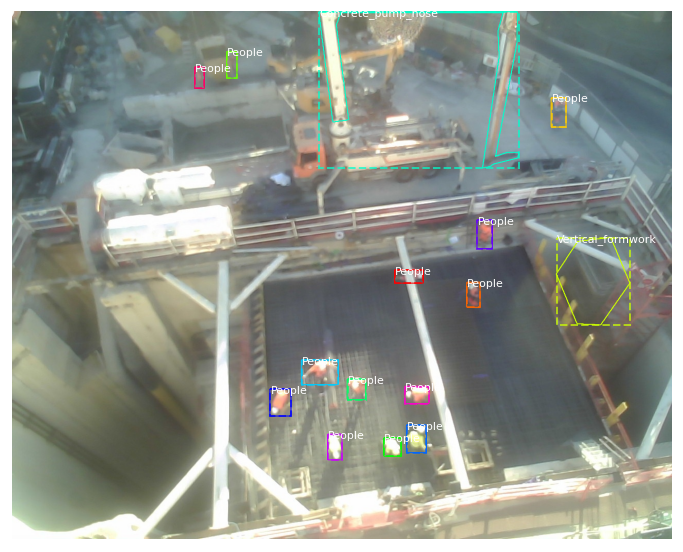

In [12]:
dataset_inference = dataset_val
# Test on a random image
image_id = random.choice(dataset_inference.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_inference, config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_inference.class_names_preset, figsize=(12, 12))

Processing 1 images
image                    shape: (1024, 1280, 3)       min:   38.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1280, 3)    min:  -70.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1280.00000  int64
anchors                  shape: (1, 327360, 4)        min:   -0.08847  max:    1.02591  float32


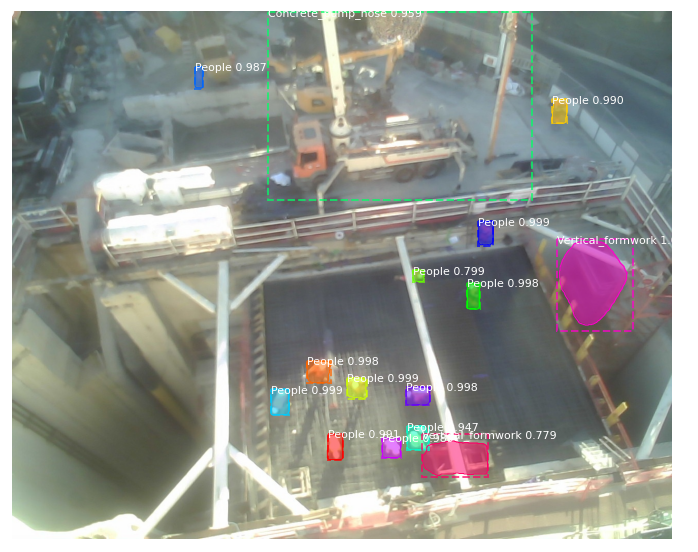

In [13]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_inference.class_names_preset, r['scores'], figsize=(12, 12))

## 3.2. Single Sample AP50/AP75

In [14]:
AP50, precisions50, recalls50, overlaps50 =\
    utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                     r["rois"], r["class_ids"], r["scores"], r['masks'], 0.5)
AP75, precisions75, recalls75, overlaps75 =\
    utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                     r["rois"], r["class_ids"], r["scores"], r['masks'], 0.75)

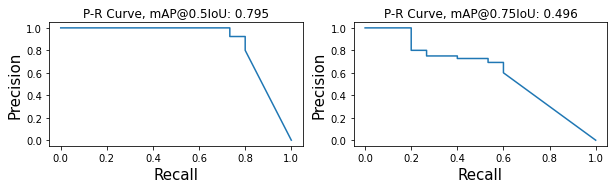

In [15]:
fig = plt.figure(figsize=(10,5))

plt.subplot(221)
plt.plot(recalls50, precisions50)
plt.xlabel("Recall", fontsize=15)
plt.ylabel("Precision", fontsize=15)
plt.title(f"P-R Curve, mAP@0.5IoU: {round(AP50,3)}")

plt.subplot(222)
plt.plot(recalls75, precisions75)
plt.xlabel("Recall", fontsize=15)
plt.ylabel("Precision", fontsize=15)
plt.title(f"P-R Curve, mAP@0.75IoU: {round(AP75,3)}")
plt.show()

In [16]:
mAP5095 = utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                                 r["rois"], r["class_ids"],
                                 r["scores"], r['masks'])

AP @0.50:	 0.795
AP @0.55:	 0.693
AP @0.60:	 0.693
AP @0.65:	 0.693
AP @0.70:	 0.579
AP @0.75:	 0.496
AP @0.80:	 0.295
AP @0.85:	 0.083
AP @0.90:	 0.008
AP @0.95:	 0.000
AP @0.50-0.95:	 0.433


## 3.3. Single Sample Match Matrix

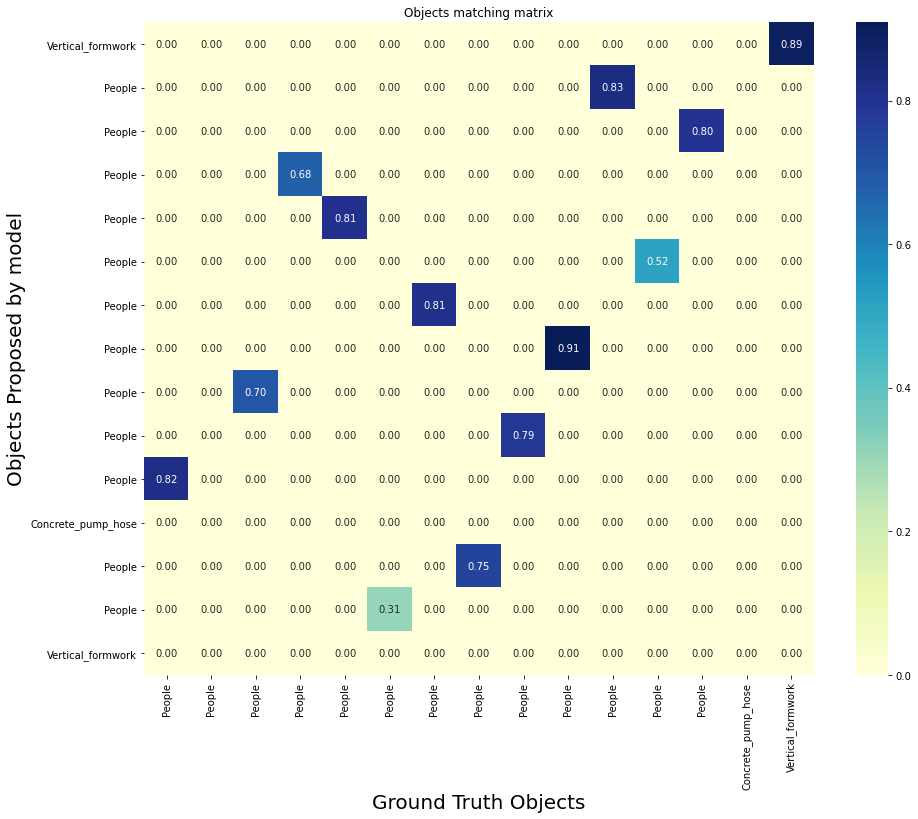

In [17]:
gt_class_names = [dataset_inference.class_names_preset[i] for i in gt_class_id]
pred_class_names = [dataset_inference.class_names_preset[i] for i in r["class_ids"]]

df_mm = pd.DataFrame(overlaps50, index=pred_class_names,
                 columns=gt_class_names)
plt.figure(figsize=(15, 12))
sn.heatmap(df_mm, annot=True, cmap="YlGnBu", fmt="2.2f")
plt.xlabel("Ground Truth Objects", fontsize=20)
plt.ylabel("Objects Proposed by model", fontsize=20)
plt.title("Objects matching matrix")
plt.show()

# 4. Evaluate dataset

## 4.1. P-R Curve

<font color='red'>Dismiss the indexing after dataset_inference.image_ids to evaluate model on full valid set.</font>

In [18]:
dataset_inference = dataset_val
IoU = 0.50

object_matches = []

for image_id in tqdm.tqdm(dataset_inference.image_ids[:10]):
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_inference, config,
                               image_id, use_mini_mask=False)
    results = model.detect([original_image], verbose=0)
    r = results[0]

    gt_matches, pred_matches, overlaps = utils.compute_matches(
        gt_bbox, gt_class_id, gt_mask, r["rois"],
        r["class_ids"], r["scores"], r['masks'], IoU)

    object_matches += get_object_matches(r, pred_matches, gt_matches, gt_class_id, image_id, overlaps)

100%|██████████| 10/10 [00:43<00:00,  4.31s/it]


In [19]:
load_from_legacy_result = True
if load_from_legacy_result:
    df = pd.read_pickle(f'./evaluation_results_val_{CHECKPOINT_EPOCH}.pkl')
else:
    df = pd.DataFrame(object_matches)
    df.to_pickle(f'./evaluation_results_val_{CHECKPOINT_EPOCH}.pkl')

In [20]:
df["sample_id"] = df["image_id"].apply(lambda x: dataset_inference.image_info[x]['id'])
df = df.merge(records[["sample_id", "construction_site"]], on="sample_id")

In [21]:
df.construction_site.value_counts()

Marseille_01                      4531
Analytic                          2274
Nouveau_campus_03                 2118
Devisubox2_06                     1265
Roissy_02                          454
BioSAV_BIofiltration_18mois_05     333
Name: construction_site, dtype: int64

In [22]:
construction_site_list = [b[0] for b in list(records.construction_site.value_counts().items())][1:]

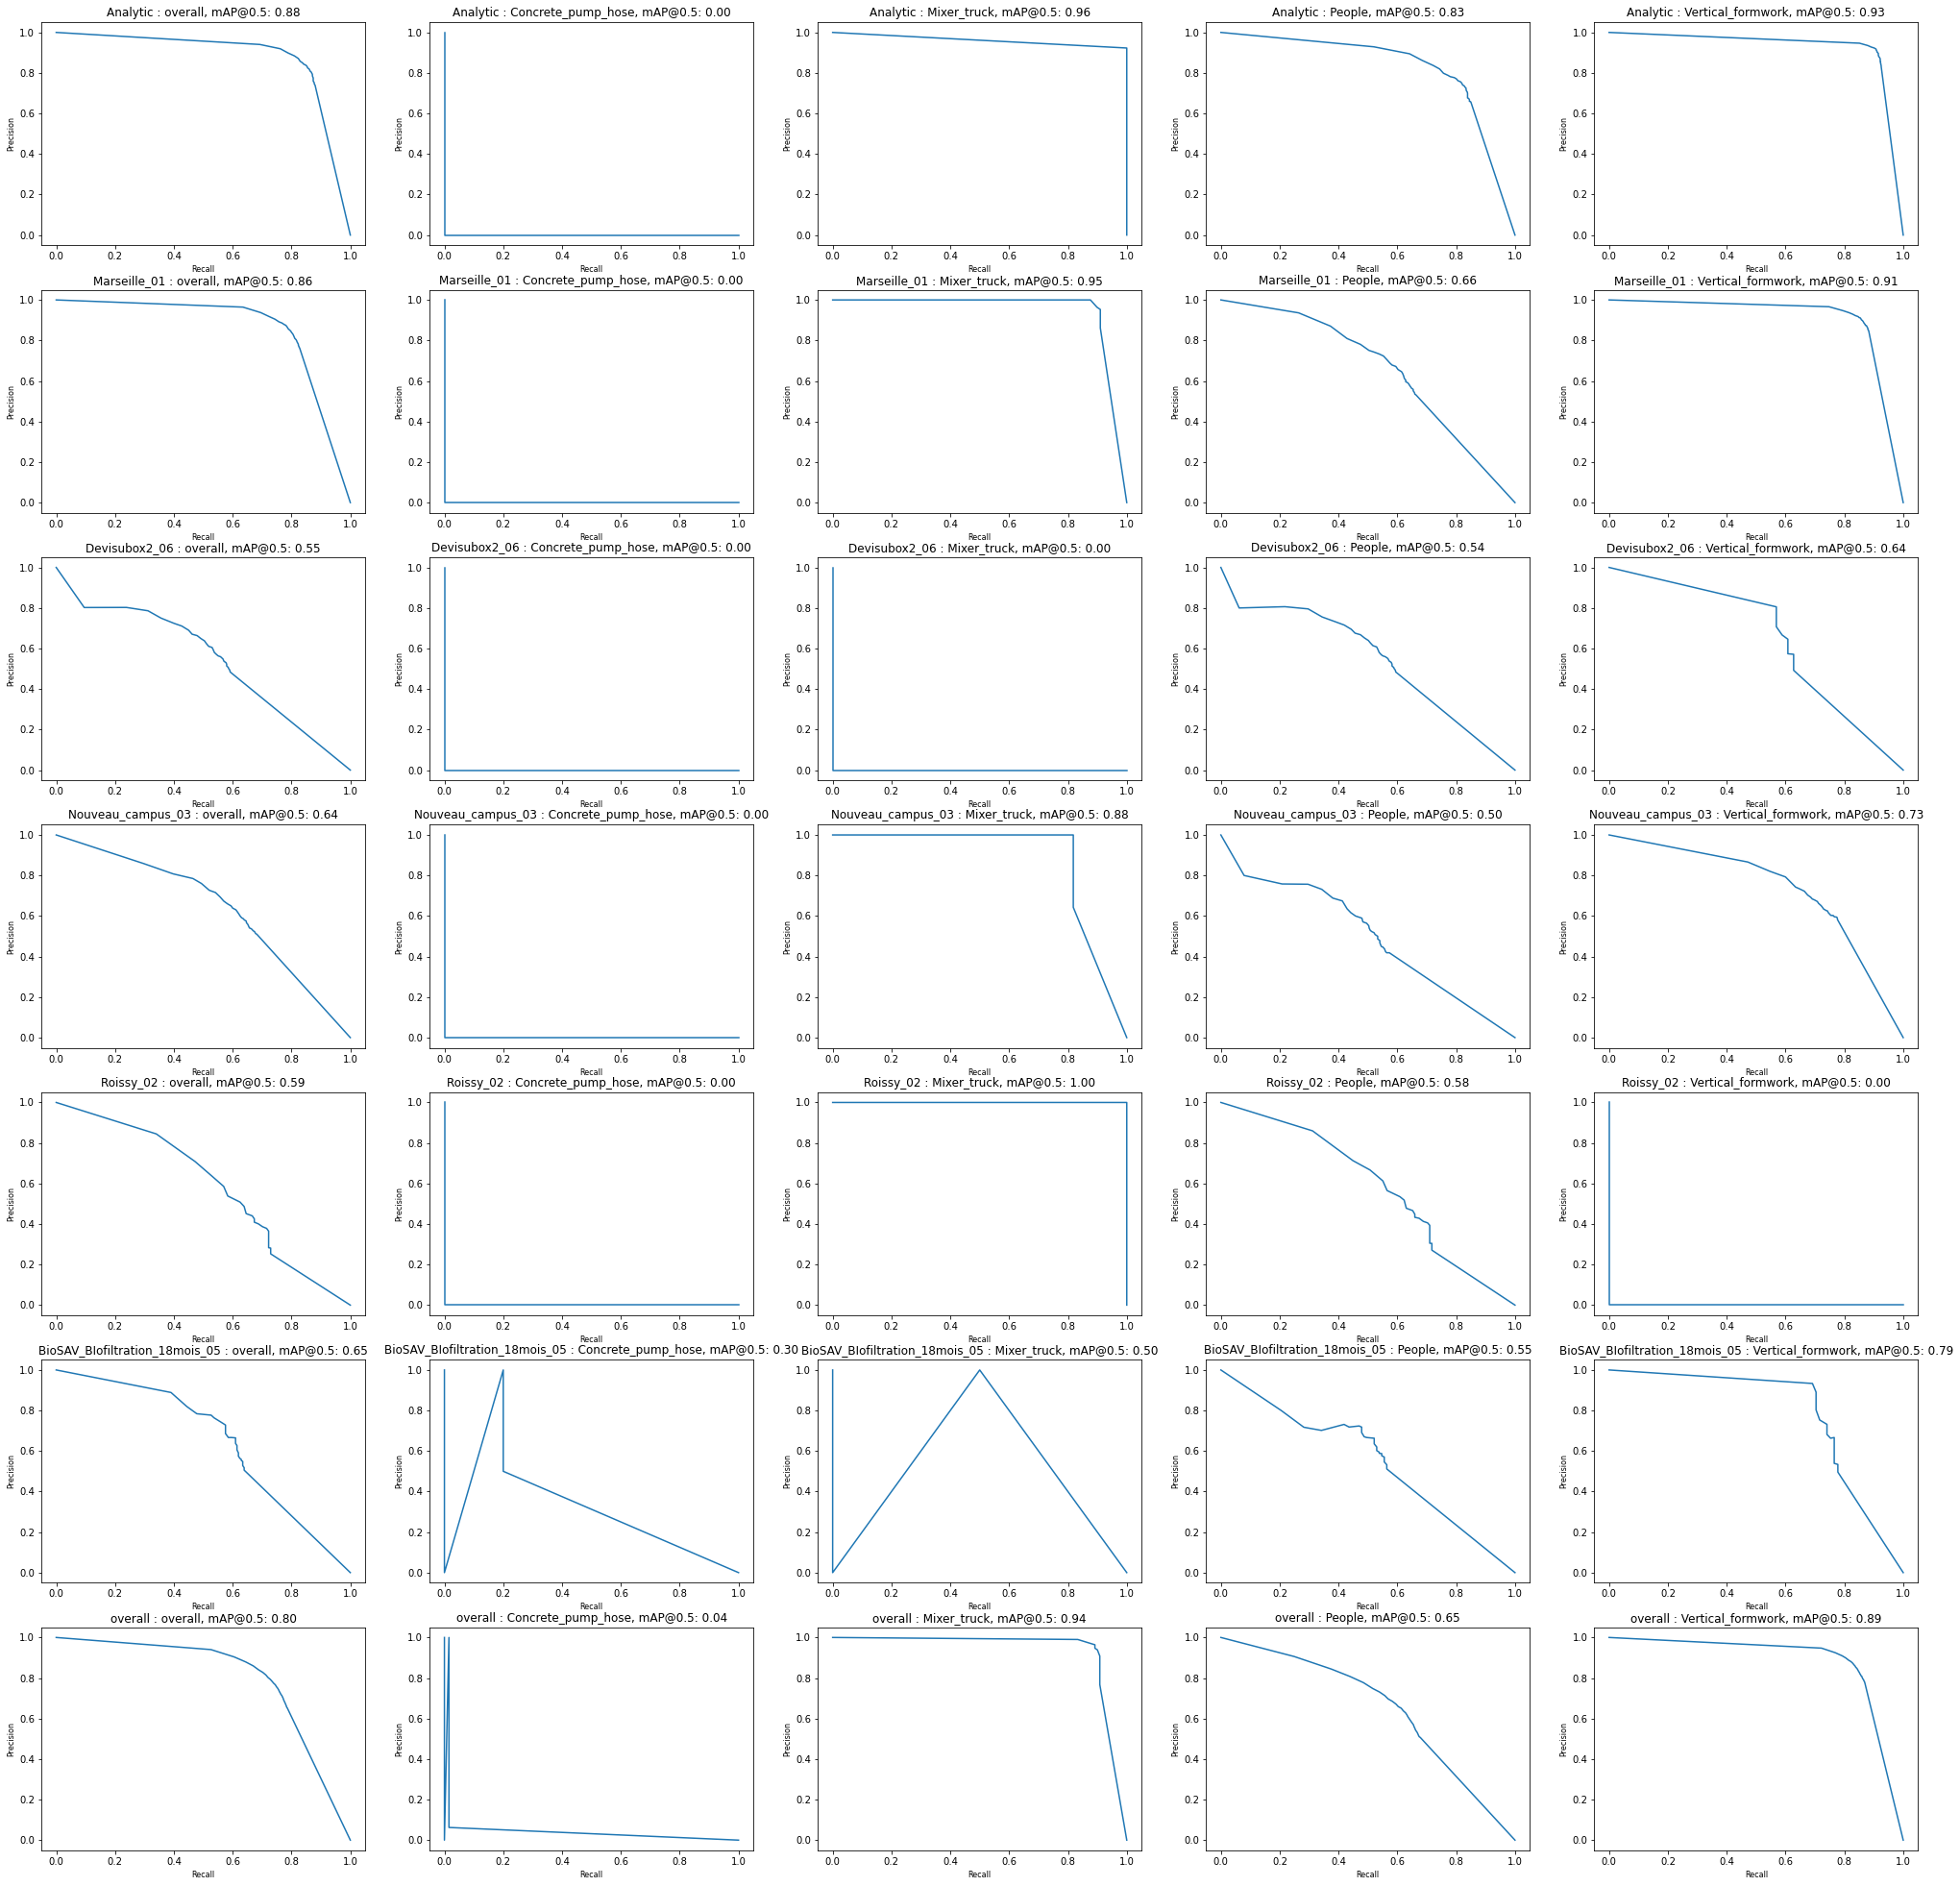

In [23]:
_, axs = plt.subplots(7, 5, figsize=(35, 35))
mAPs = np.zeros((7, 5))
for class_id in range(len(dataset_inference.class_names_preset)):
    if class_id == 0:
        df_class = df
        class_name = "overall"
    else:
        df_class = df[(df.pred_class == class_id)|(df.gt_class == class_id)]
        class_name = dataset_inference.class_names_preset[class_id]

    precisions, recalls = get_precision_recall(df_class)
    mAP = calculate_ap_from_pr(precisions, recalls)

    axs[6, class_id].plot(recalls, precisions)
    axs[6, class_id].set_xlabel("Recall", fontsize=8)
    axs[6, class_id].set_ylabel("Precision", fontsize=8)
    axs[6, class_id].set_title(f"overall : {class_name}, mAP@0.5: {mAP:.2f}", fontsize=12)
    mAPs[6, class_id] = mAP

for index, construction_site in enumerate(construction_site_list):
    df_construction_site = df[df.construction_site == construction_site]
    for class_id in range(len(dataset_inference.class_names_preset)):
        if class_id == 0:
            df_class = df_construction_site
            class_name = "overall"
        else:
            df_class = df_construction_site[(df_construction_site.pred_class == class_id) |
                                            (df_construction_site.gt_class == class_id)]
            class_name = dataset_inference.class_names_preset[class_id]


        precisions, recalls = get_precision_recall(df_class)
        mAP = calculate_ap_from_pr(precisions, recalls)

        axs[index, class_id].plot(recalls, precisions)
        axs[index, class_id].set_xlabel("Recall", fontsize=8)
        axs[index, class_id].set_ylabel("Precision", fontsize=8)
        axs[index, class_id].set_title(f"{construction_site} : {class_name}, mAP@0.5: {mAP:.2f}", fontsize=12)
        mAPs[index, class_id] = mAP

Text(0.5, 1.0, 'Overall P-R curve: mAP@0.5: 0.80')

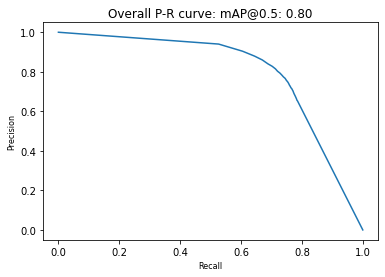

In [24]:
precisions, recalls = get_precision_recall(df)
mAP = calculate_ap_from_pr(precisions, recalls)

plt.plot(recalls, precisions)
plt.xlabel("Recall", fontsize=8)
plt.ylabel("Precision", fontsize=8)
plt.title(f"Overall P-R curve: mAP@0.5: {mAP:.2f}", fontsize=12)

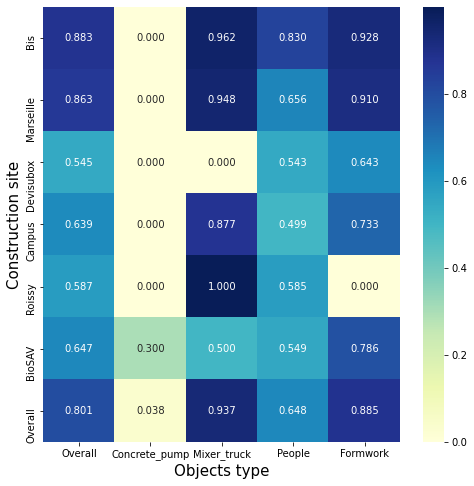

In [25]:
# mAP
plt.figure(figsize = (8, 8))
sn.heatmap(pd.DataFrame(mAPs, index = ["Bis"] + ["Marseille", "Devisubox", "Campus", "Roissy", "BioSAV"] + ["Overall"],\
                 columns= ["Overall", "Concrete_pump", "Mixer_truck", "People", "Formwork"]), annot=True, cmap="YlGnBu", fmt="2.3f")
plt.xlabel("Objects type", fontsize=15)
plt.ylabel("Construction site", fontsize=15)
# plt.title("mAP@IoU0.5 for each class and construction site", fontsize=28)
plt.show()

In [26]:
# mIOU
score_threshold = 0.9
mIoU = np.zeros((7, 5))
df_pred = df[df["pred_class"] >= 0]
for class_id in range(len(dataset_inference.class_names_preset)):
    df_site = df_pred
    if class_id == 0:
        df_class = df_site
    else:
        df_class = df_site[df_site["pred_class"] == class_id]

    df_class = df_class[df_class["pred_score"] > score_threshold]
    IoU = np.mean(df_class.highest_mIoU.values)
    if IoU is not None:
        mIoU[6, class_id] = IoU

for index, construction_site in enumerate(construction_site_list):
    df_site = df_pred[df_pred["construction_site"] == construction_site]
    for class_id in range(len(dataset_inference.class_names_preset)):
        if class_id == 0:
            df_class = df_site
        else:
            df_class = df_site[df_site["pred_class"] == class_id]

        df_class = df_class[df_class["pred_score"] > score_threshold]
        IoU = np.mean(df_class.highest_mIoU.values)
        if IoU is not None:
            mIoU[index, class_id] = IoU


/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


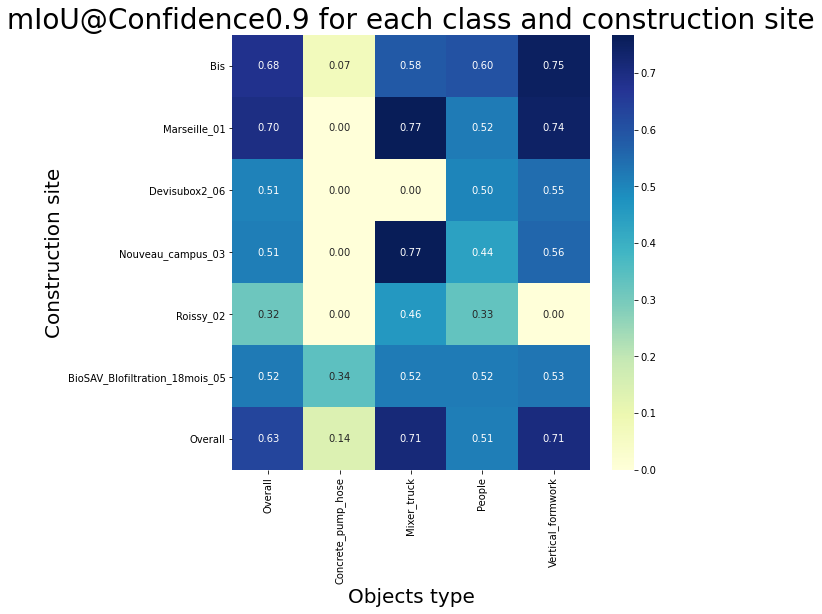

In [27]:
mIoU[np.isnan(mIoU)] = 0
plt.figure(figsize = (8, 8))
sn.heatmap(pd.DataFrame(mIoU, index = ["Bis"] + construction_site_list[1:] + ["Overall"],\
                 columns= ["Overall", "Concrete_pump_hose", "Mixer_truck", "People", "Vertical_formwork"]), annot=True, cmap="YlGnBu", fmt="2.2f")
plt.xlabel("Objects type", fontsize=20)
plt.ylabel("Construction site", fontsize=20)
plt.title("mIoU@Confidence0.9 for each class and construction site", fontsize=28)
plt.show()

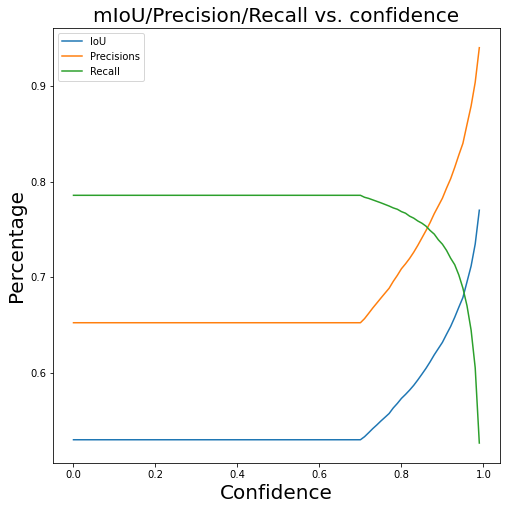

In [28]:
score_threshold = np.arange(0, 1.0, 0.01)
IoUs = []
for thres in score_threshold:
    df_pred = df[df["pred_class"] >= 0]
    df_pred = df_pred[df_pred["pred_score"] > thres]
    IoUs.append(np.mean(df_pred.highest_mIoU.values))
plt.figure(figsize=(8, 8))
plt.plot(score_threshold, IoUs, label="IoU")
plt.plot(score_threshold, precisions[1:-1], label="Precisions")
plt.plot(score_threshold, recalls[1:-1], label="Recall")
plt.legend()
plt.xlabel("Confidence", fontsize=20)
plt.ylabel("Percentage", fontsize=20)
plt.title("mIoU/Precision/Recall vs. confidence", fontsize=20)
plt.show()